---

## Bioinformatics - Project no. 2
## *CpG islands and DNA Methylation analysis*

---

### Import packages

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

### Functions

In [138]:
def prepare_bed(df, chrN, start, stop):
    """
    Function gets 'chrN', 'start' and 'stop' columns from data frame 'df' in bed format
    and get rows only for autosomal chromosomes
    """
    
    df = df.iloc[:, chrN:(stop + 1)]
    df.rename(columns = {chrN: "chrN", start: "start", stop: "stop"}, inplace = True)
    
    return sort_by_chromosome_number(df)


def prepare_chr_num_column(df):
    """
    Function prepares chr_num column from chrN column from data frame 'df'
    """
    
    df = df.copy()
    
    df["chr_num"] = df.apply(lambda row: row.chrN[3:], axis = 1) 

    l_str = [str(x) for x in range(1, 23)]
    l_str

    df = df.loc[df["chr_num"].isin(l_str)]
    df["chr_num"] = df["chr_num"].astype("int")
    
    return df


def sort_by_chromosome_number(df):
    """
    Function sorts data frame 'df' by chromosome number
    """
    
    df = prepare_chr_num_column(df)
    
    df = df.sort_values(by = ["chr_num", "start", "stop"]).reset_index(drop = True)
    df = df.drop(["chr_num"], axis = 1)
    
    return df


def append_data_frames(areas_full, df, area_name):
    """
    Function appends data frame 'df' to 'areas_full' data frame
    and fill column area with value 'area_name'
    """
    
    df = df.copy()
    df["area"] = area_name
    
    areas_full = areas_full.append(df)
    
    return areas_full


def add_count_by_chrN(areas_full, DNA_methylation, chrN, counts_dict):
    """
    Function counts methylations located in CpG islands, Shores, Shelves and Seas
    for chromosome 'chrN' and adds results to dictionary 'counts_dict'
    """
    
    areas_full_chrN = areas_full.loc[chrN]
    DNA_methylation_chrN = DNA_methylation.loc[chrN]
    n_row_DNA_methylation_chrN = DNA_methylation_chrN.shape[0]

    i = 0
    methylation = DNA_methylation_chrN.iloc[i]
    
    for _, row in areas_full_chrN.iterrows():
        while row.start <= methylation.middle < row.stop:
            counts_dict[row.area] += 1
            i += 1
            
            if i >= n_row_DNA_methylation_chrN:
                return
            
            methylation = DNA_methylation_chrN.iloc[i]

---

### Read data from files

In [3]:
CpG_islands = pd.read_csv("./data/cpgIslandExt.txt", sep = "\t", header = None)
CpG_islands.head()

,0,1,2,3,4,5,6,7,8,9,10
0,585,chr1,28735,29810,CpG: 116,1075,116,787,21.6,73.2,0.83
1,586,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64
2,587,chr1,327790,328229,CpG: 29,439,29,295,13.2,67.2,0.62
3,588,chr1,437151,438164,CpG: 84,1013,84,734,16.6,72.5,0.64
4,588,chr1,449273,450544,CpG: 99,1271,99,777,15.6,61.1,0.84


In [120]:
DNA_methylation = pd.read_csv("./data/HAIB.A549.EtOH.Rep.3.bed", sep = "\t", header = None)
DNA_methylation.head()

,0,1,2,3,4,5,6,7,8
0,chr16,53468112,53468162,cg00000029,486,+,53468112,53468162,"128,0,128"
1,chr3,37459206,37459256,cg00000108,916,+,37459206,37459256,"255,127,0"
2,chr3,171916037,171916087,cg00000109,815,+,171916037,171916087,"255,127,0"
3,chr1,91194674,91194724,cg00000165,806,-,91194674,91194724,"255,127,0"
4,chr8,42263294,42263344,cg00000236,843,-,42263294,42263344,"255,127,0"


In [5]:
chromosomes_sizes = pd.read_csv("./data/hg19.chrom.sizes.txt", sep = "\t", header = None)
chromosomes_sizes.head()

,0,1
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260


---

### Prepare data in bed format

In [6]:
CpG_islands = prepare_bed(CpG_islands, 1, 2, 3)
CpG_islands.head()

,chrN,start,stop
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544


In [121]:
DNA_methylation = prepare_bed(DNA_methylation, 0, 1, 2)
DNA_methylation.head()

,chrN,start,stop
0,chr1,15865,15915
1,chr1,18827,18877
2,chr1,29407,29457
3,chr1,29425,29475
4,chr1,29435,29485


In [8]:
chromosomes_sizes.rename(columns={0: "chrN", 1: "size"}, inplace = True)
chromosomes_sizes = prepare_chr_num_column(chromosomes_sizes)
chromosomes_sizes = chromosomes_sizes.sort_values(by = ["chr_num"]).reset_index(drop = True)
chromosomes_sizes = chromosomes_sizes.drop(["chr_num"], axis = 1)
    
chromosomes_sizes.head()

,chrN,size
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260


---

### Task 1

In [9]:
# Prepare coordinates of Shores, Shelves and Seas

max_step = 2000
n_row = CpG_islands.shape[0]
df_full = CpG_islands.copy()


df_full["shore_stop"] = 1
df_full["shore_start"] = 1
df_full["shelve_stop"] = 1
df_full["shelve_start"] = 1
df_full["sea_stop"] = 1


df_full = df_full[["chrN", "shelve_start", "shore_start", "start", "stop", "shore_stop", "shelve_stop", "sea_stop"]]


# First row
df_full.loc[0, "shore_start"] = max(1, df_full.loc[0, "start"] - max_step)
df_full.loc[0, "shelve_start"] = max(1, df_full.loc[0, "shore_start"] - max_step)


for i in range(1, n_row):        
    if df_full.loc[i-1, "chrN"] == df_full.loc[i, "chrN"]:
        df_full.loc[i-1, "shore_stop"] = min(df_full.loc[i, "start"], df_full.loc[i-1, "stop"] + max_step)
        df_full.loc[i, "shore_start"] = max(df_full.loc[i-1, "shore_stop"], df_full.loc[i, "start"] - max_step)
        df_full.loc[i-1, "shelve_stop"] = min(df_full.loc[i, "shore_start"], df_full.loc[i-1, "shore_stop"] + max_step)
        df_full.loc[i, "shelve_start"] = max(df_full.loc[i-1, "shelve_stop"], df_full.loc[i, "shore_start"] - max_step)
        df_full.loc[i-1, "sea_stop"] = df_full.loc[i, "shelve_start"]
    else:
        size_i_1 = chromosomes_sizes.loc[chromosomes_sizes["chrN"] == df_full.loc[i-1, "chrN"]].reset_index(drop = True)
        size_i_1 = size_i_1.loc[0, "size"]

        df_full.loc[i-1, "shore_stop"] = min(size_i_1, df_full.loc[i-1, "stop"] + max_step)
        df_full.loc[i-1, "shelve_stop"] = min(size_i_1, df_full.loc[i-1, "shore_stop"] + max_step)
        df_full.loc[i-1, "sea_stop"] = size_i_1
        
        df_full.loc[i, "shore_start"] = max(1, df_full.loc[i, "start"] - max_step)
        df_full.loc[i, "shelve_start"] = max(1, df_full.loc[i, "shore_start"] - max_step)


# Last row
size_i_1 = chromosomes_sizes.loc[chromosomes_sizes["chrN"] == df_full.loc[n_row-1, "chrN"]].reset_index(drop = True)
size_i_1 = size_i_1.loc[0, "size"]
df_full.loc[n_row-1, "shore_stop"] = min(size_i_1, df_full.loc[n_row-1, "stop"] + max_step)
df_full.loc[n_row-1, "shelve_stop"] = min(size_i_1, df_full.loc[n_row-1, "shore_stop"] + max_step)
df_full.loc[n_row-1, "sea_stop"] = size_i_1

In [10]:
df_full.head()

,chrN,shelve_start,shore_start,start,stop,shore_stop,shelve_stop,sea_stop
0,chr1,24735,26735,28735,29810,31810,33810,131124
1,chr1,131124,133124,135124,135563,137563,139563,323790
2,chr1,323790,325790,327790,328229,330229,332229,433151
3,chr1,433151,435151,437151,438164,440164,442164,445273
4,chr1,445273,447273,449273,450544,452544,454544,529219


In [11]:
df_full.tail()

,chrN,shelve_start,shore_start,start,stop,shore_stop,shelve_stop,sea_stop
26636,chr22,51131670,51133670,51135670,51136118,51138118,51140118,51140118
26637,chr22,51140118,51140802,51142802,51143308,51145308,51147308,51154386
26638,chr22,51154386,51156386,51158386,51160060,51162060,51164060,51165027
26639,chr22,51165027,51167027,51169027,51170019,51172019,51174019,51217772
26640,chr22,51217772,51219772,51221772,51222317,51224317,51226317,51304566


In [18]:
# Prepare data frames with coordinates of Shores, Shelves and Seas in BED format

Shores = pd.DataFrame(columns = ["chrN", "start", "stop"])
Shelves = pd.DataFrame(columns = ["chrN", "start", "stop"])
Seas = pd.DataFrame(columns = ["chrN", "start", "stop"])


if df_full.loc[0, "shelve_start"] > 1:
    Seas = Seas.append({"chrN": df_full.loc[0, "chrN"], "start": 1, "stop": df_full.loc[0, "shelve_start"]}, ignore_index = True)

    
for i in range(0, n_row):
    chrN = df_full.loc[i, "chrN"]
    
    if i > 0 and df_full.loc[i-1, "chrN"] != chrN and df_full.loc[i, "shelve_start"] > 1:
        Seas = Seas.append({"chrN": df_full.loc[i, "chrN"], "start": 1, "stop": df_full.loc[i, "shelve_start"]}, ignore_index = True)
    
    if df_full.loc[i, "shore_start"] > df_full.loc[i, "shelve_start"]:
        Shelves = Shelves.append({"chrN": chrN, "start": df_full.loc[i, "shelve_start"], "stop": df_full.loc[i, "shore_start"]}, ignore_index = True)
    
    if df_full.loc[i, "start"] > df_full.loc[i, "shore_start"]:
        Shores = Shores.append({"chrN": chrN, "start": df_full.loc[i, "shore_start"], "stop": df_full.loc[i, "start"]}, ignore_index = True)
    
    if df_full.loc[i, "shore_stop"] > df_full.loc[i, "stop"]:
        Shores = Shores.append({"chrN": chrN, "start": df_full.loc[i, "stop"], "stop": df_full.loc[i, "shore_stop"]}, ignore_index = True)

    if df_full.loc[i, "shelve_stop"] > df_full.loc[i, "shore_stop"]:
        Shelves = Shelves.append({"chrN": chrN, "start": df_full.loc[i, "shore_stop"], "stop": df_full.loc[i, "shelve_stop"]}, ignore_index = True)

    if df_full.loc[i, "sea_stop"] > df_full.loc[i, "shelve_stop"]:
        Seas = Seas.append({"chrN": chrN, "start": df_full.loc[i, "shelve_stop"], "stop": df_full.loc[i, "sea_stop"]}, ignore_index = True)

In [19]:
Shores.head()

,chrN,start,stop
0,chr1,26735,28735
1,chr1,29810,31810
2,chr1,133124,135124
3,chr1,135563,137563
4,chr1,325790,327790


In [20]:
Shelves.head()

,chrN,start,stop
0,chr1,24735,26735
1,chr1,31810,33810
2,chr1,131124,133124
3,chr1,137563,139563
4,chr1,323790,325790


In [21]:
Seas.head()

,chrN,start,stop
0,chr1,1,24735
1,chr1,33810,131124
2,chr1,139563,323790
3,chr1,332229,433151
4,chr1,442164,445273


In [22]:
# Save data frames with coordinates of Shores, Shelves and Seas in BED format to files
CpG_islands.to_csv("./results/CpG_islands.bed", sep = "\t", header = False, index = False)
Shores.to_csv("./results/Shores.bed", sep = "\t", header = False, index = False)
Shelves.to_csv("./results/Shelves.bed", sep = "\t", header = False, index = False)
Seas.to_csv("./results/Seas.bed", sep = "\t", header = False, index = False)

---

### Task 2

In [122]:
# Set DNA Methylation coordinates as the middle of its range
DNA_methylation["middle"] = DNA_methylation.apply(lambda row: int((row.start + row.stop) / 2), axis = 1)
DNA_methylation.head()

,chrN,start,stop,middle
0,chr1,15865,15915,15890
1,chr1,18827,18877,18852
2,chr1,29407,29457,29432
3,chr1,29425,29475,29450
4,chr1,29435,29485,29460


---

### Task 3

In [123]:
# Prepare data frame to count DNA Methylations located in all areas

areas_full = pd.DataFrame(columns = ["chrN", "start", "stop", "area"])
areas_full = append_data_frames(areas_full, CpG_islands, "CpG_island")
areas_full = append_data_frames(areas_full, Shores, "Shore")
areas_full = append_data_frames(areas_full, Shelves, "Shelve")
areas_full = append_data_frames(areas_full, Seas, "Sea")

areas_full = sort_by_chromosome_number(areas_full)

In [124]:
areas_full.head()

,chrN,start,stop,area
0,chr1,1,24735,Sea
1,chr1,24735,26735,Shelve
2,chr1,26735,28735,Shore
3,chr1,28735,29810,CpG_island
4,chr1,29810,31810,Shore


In [125]:
areas_full.tail()

,chrN,start,stop,area
137536,chr22,51219772,51221772,Shore
137537,chr22,51221772,51222317,CpG_island
137538,chr22,51222317,51224317,Shore
137539,chr22,51224317,51226317,Shelve
137540,chr22,51226317,51304566,Sea


In [126]:
# Prepare list of chrN
chrN_list = list(chromosomes_sizes["chrN"])

In [139]:
# Prepare dictionary to count DNA Methylations located in all areas
counts_dict = {
    "CpG_island": 0,
    "Shore": 0,
    "Shelve": 0,
    "Sea": 0
}

In [128]:
# Set index on chrN column
areas_full = areas_full.set_index("chrN")
areas_full.head()

,start,stop,area
chrN,,,
chr1,1,24735,Sea
chr1,24735,26735,Shelve
chr1,26735,28735,Shore
chr1,28735,29810,CpG_island
chr1,29810,31810,Shore


In [129]:
# Set index on chrN column
DNA_methylation = DNA_methylation.set_index("chrN")
DNA_methylation.head()

,start,stop,middle
chrN,,,
chr1,15865,15915,15890
chr1,18827,18877,18852
chr1,29407,29457,29432
chr1,29425,29475,29450
chr1,29435,29485,29460


In [142]:
# Count DNA Methylations located in all areas
for chrN in chrN_list:
    add_count_by_chrN(areas_full, DNA_methylation, chrN, counts_dict)

In [143]:
counts_dict

{'CpG_island': 132094, 'Shore': 122913, 'Shelve': 45457, 'Sea': 170406}

In [281]:
# Number of methylations
n_methylations = DNA_methylation.shape[0]

In [172]:
# Dict to df
counts_df = pd.DataFrame.from_dict(counts_dict, orient = "index", columns = ["counts"])
counts_df.reset_index(level = 0, inplace = True)
counts_df.rename(columns = {"index": "area"}, inplace = True)
counts_df

,area,counts
0,CpG_island,132094
1,Shore,122913
2,Shelve,45457
3,Sea,170406


In [282]:
# Check if all methylations were counted
n_methylations == np.sum(counts_df["counts"])

True

In [207]:
# Add column with percentage
counts_df["percentage"] = counts_df.apply(lambda row: row.counts / n_methylations, axis = 1)
counts_df

,area,counts,percentage
0,CpG_island,132094,0.280532
1,Shore,122913,0.261034
2,Shelve,45457,0.096538
3,Sea,170406,0.361896


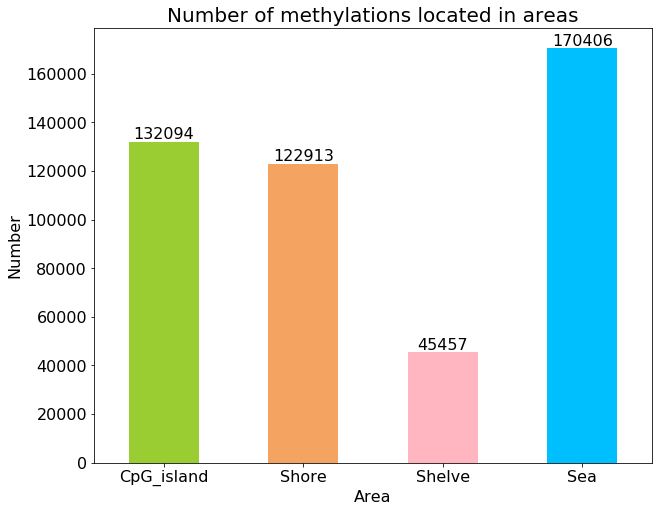

In [279]:
# Counts chart

height = counts_df["counts"]
bars = counts_df["area"]
y_pos = np.arange(len(bars))

plt.figure(figsize = (10, 8))

ax = height.plot(kind = "bar", color = ["yellowgreen", "sandybrown", "lightpink", "deepskyblue"])
ax.set_title("Number of methylations located in areas", size = 20)
ax.set_xlabel("Area", size = 16)
ax.set_ylabel("Number", size = 16)
ax.set_xticklabels(bars, rotation = "horizontal", size = 16)
plt.yticks(size = 16)

rects = ax.patches

labels = [i for i in height]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.002, label, ha = "center", va = "bottom", size = 16)

plt.show()

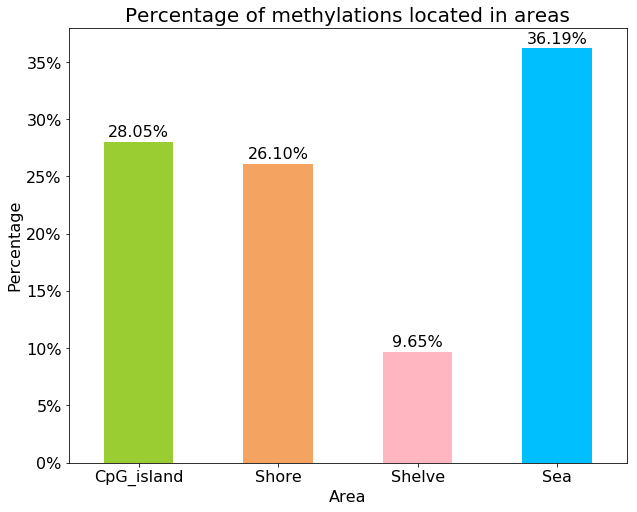

In [278]:
# Percentage chart

height = counts_df["percentage"]
bars = counts_df["area"]
y_pos = np.arange(len(bars))

plt.figure(figsize = (10, 8))

ax = height.plot(kind = "bar", color = ["yellowgreen", "sandybrown", "lightpink", "deepskyblue"])
ax.set_title("Percentage of methylations located in areas", size = 20)
ax.set_xlabel("Area", size = 16)
ax.set_ylabel("Percentage", size = 16)
ax.set_xticklabels(bars, rotation = "horizontal", size = 16)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], size = 16)

rects = ax.patches

labels = ["{:.2%}".format(i) for i in height]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.002, label, ha = "center", va = "bottom", size = 16)

plt.show()

---